In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR
import os

import gc

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# finbert sentiment data
# df = pd.read_pickle('/Users/dan/Desktop/Fin7036_NLP/Non-JaneStreet/data/final_map_table.pkl')

,id,deberta_pos,deberta_neg,deberta_stmt_score,deberta_stmt_label,publishedDate,ticker,gsector,FAMC
0,19384755.0,0.485230,0.514770,-0.029540,negative,2016-01-02 00,amzn,25.0,29859543.24
1,19392785.0,0.486300,0.513700,-0.027400,negative,2016-01-02 00,amzn,25.0,29859543.24
2,19393933.0,0.482846,0.517154,-0.034308,negative,2016-01-02 00,amzn,25.0,29859543.24
3,19395112.0,0.483693,0.516307,-0.032613,negative,2016-01-02 00,amzn,25.0,29859543.24
4,19405295.0,0.487687,0.512313,-0.024626,negative,2016-01-02 00,amzn,25.0,29859543.24
...,...,...,...,...,...,...,...,...,...
15496726,47254062.0,0.510829,0.489171,0.021659,positive,2022-09-06 00,imxi,40.0,85245.37
15496727,47254062.0,0.510829,0.489171,0.021659,positive,2022-09-06 00,blk,40.0,10023694.50
15496728,47254061.0,0.512709,0.487291,0.025418,positive,2022-09-06 00,irt,60.0,429241.98
15496729,47254061.0,0.512709,0.487291,0.025418,positive,2022-09-06 00,jef,40.0,741283.05


In [4]:
"""whole process for data filtration"""
# if choose other data
# set path
directory = '/Users/dan/Desktop/Fin7036_NLP/Non-JaneStreet/data/deberta'

# get all Parquet file in this path
parquet_files = [f for f in os.listdir(directory) if f.endswith('.parquet')]

# read and merge all the Parquet files
df_list = []
for file in parquet_files:
    file_path = os.path.join(directory, file)
    temp_df = pd.read_parquet(file_path)
    df_list.append(temp_df)

df = pd.concat(df_list, ignore_index=True)

# use map table to filter these sentiment data
map_table = pd.read_pickle('/Users/dan/Desktop/Fin7036_NLP/Non-JaneStreet/data/final_map_table.pkl')
df = pd.merge(df, map_table, on=['id'], how='right')
# del combined_df
gc.collect()

0

In [5]:
df['date'] = [x[:10] for x in df['publishedDate']]
df = df[df['date'] >= '2017-08-17']
gc.collect()

0

In [6]:
df

,id,deberta_pos,deberta_neg,deberta_stmt_score,deberta_stmt_label,publishedDate,ticker,gsector,FAMC,date
1734240,6624480.0,0.539641,0.460359,0.079283,positive,2017-08-31 00,snn,35.0,3185327.60,2017-08-31
1734241,6624480.0,0.539641,0.460359,0.079283,positive,2017-08-31 00,pbh,35.0,268763.00,2017-08-31
1734242,6624483.0,0.537700,0.462300,0.075400,positive,2017-08-31 00,aprn,30.0,22259.64,2017-08-31
1734243,6624483.0,0.537700,0.462300,0.075400,positive,2017-08-31 00,kar,20.0,619311.15,2017-08-31
1734244,6624483.0,0.537700,0.462300,0.075400,positive,2017-08-31 00,baba,25.0,43985190.10,2017-08-31
...,...,...,...,...,...,...,...,...,...,...
15496726,47254062.0,0.510829,0.489171,0.021659,positive,2022-09-06 00,imxi,40.0,85245.37,2022-09-06
15496727,47254062.0,0.510829,0.489171,0.021659,positive,2022-09-06 00,blk,40.0,10023694.50,2022-09-06
15496728,47254061.0,0.512709,0.487291,0.025418,positive,2022-09-06 00,irt,60.0,429241.98,2022-09-06
15496729,47254061.0,0.512709,0.487291,0.025418,positive,2022-09-06 00,jef,40.0,741283.05,2022-09-06


In [7]:
# counts data
ticker_counts = pd.read_pickle('/Users/dan/Desktop/Fin7036_NLP/Non-JaneStreet/data/sNv.pkl').groupby('datadate').apply(lambda x: len(x['tic'].unique()))
ticker_counts_sector = pd.read_pickle('/Users/dan/Desktop/Fin7036_NLP/Non-JaneStreet/data/sNv.pkl').groupby(['gsector', 'datadate']).apply(lambda x: len(x['tic'].unique()))
ticker_counts = ticker_counts[(ticker_counts.index >= '2017-08-17') & (ticker_counts.index <= '2022-09-06')]
ticker_counts_sector = ticker_counts_sector[(ticker_counts_sector.index.get_level_values(1) >= '2017-08-17'
                                            ) & (ticker_counts_sector.index.get_level_values(1) <= '2022-09-06')]

In [19]:
def sentiment_cluster(df_, stock_counts, freq='d', impact=3):
    """ps: 1. some stocks have many news during same period, we should avoid double counting.
           2. """
    df_ = df_.copy()
    if freq == 'h':
        freq_col = 'publishedDate'
        stock_counts.name = 'count'
        df_ = pd.merge(df_, stock_counts, left_on='date', right_index=True, how='left')
        stock_counts = df_[['count', freq_col]].drop_duplicates().set_index([freq_col])
    else:
        freq_col = 'date'
        stock_counts.name = 'count'
    # for the repeated news about the same stock at a certain period, we take the average.
    temp_senti_s = df_.groupby(['ticker', freq_col]).apply(lambda x: x[['deberta_pos', 'deberta_neg']].mean(axis=0))
    # suppose the stocks have no news remain the same sentiment score as last period.
    temp_senti_freq = temp_senti_s.groupby(level=1).mean()
    temp_count_freq = temp_senti_s.groupby(level=1).apply(lambda x: x.shape[0])
    temp_count_freq.name = 'inner_count'
    temp_merge = pd.concat([stock_counts, temp_count_freq, temp_senti_freq], axis=1).sort_index().ffill()
    cluster_dict = {'deberta_pos': [], 'deberta_neg': []}  #, 'finbert_neu': []}
    last_senti = {'deberta_pos': temp_merge.head(1)['deberta_pos'].values[0],
                  'deberta_neg': temp_merge.head(1)['deberta_neg'].values[0]}
                #   'finbert_neu': temp_merge.head(1)['finbert_neu'].values[0]}
    for ind, row in temp_merge.iterrows():
        for s in ['deberta_pos', 'deberta_neg']:
            temp_put = (row[s] * impact * row['inner_count'] + last_senti[s] * (row['count'] - row['inner_count'])
                           ) / (impact * row['inner_count'] + row['count'] - row['inner_count'])
            
            cluster_dict[s].append(temp_put)
            last_senti[s] = temp_put
    return pd.DataFrame(data=cluster_dict, index=temp_merge.index)


def test_market(daily_senti, stock_counts, market_proxy):
    pass


def sector_cluster(df_, stock_counts_sector):
    sec_dict = {}
    for sector, group in df_.groupby('gsector'):
        tc = stock_counts_sector[stock_counts_sector.index.get_level_values(0) == sector].reset_index(level=0, drop=True)
        temp_h = sentiment_cluster(group, tc, 'h')
        temp_d = sentiment_cluster(group, tc, 'd')
        sec_dict[sector] = {'h': temp_h, 'd': temp_d}
    return sec_dict

In [24]:
deberta_cluster_sector = sector_cluster(df, ticker_counts_sector)

In [41]:
import pickle
# Extract daily DataFrames from all cluster groups
daily_data = {
    cluster: data['d']  # Extract daily ('d') timeframe
    for cluster, data in deberta_cluster_sector.items()
}

# Save daily data only
with open('deberta_daily_clusters.pkl', 'wb') as f:
    pickle.dump(daily_data, f)

In [38]:
deberta_cluster_sector

{10.0: {'h':                deberta_pos  deberta_neg
  publishedDate                          
  2017-08-17 00     0.538897     0.461103
  2017-08-18 00     0.538553     0.461447
  2017-08-19 00     0.538531     0.461468
  2017-08-20 00     0.538220     0.461780
  2017-08-21 00     0.538462     0.461538
  ...                    ...          ...
  2022-09-04 00     0.510548     0.489452
  2022-09-05 00     0.510688     0.489312
  2022-09-06 00     0.510666     0.489334
  2022-09-07 00     0.510648     0.489352
  2022-09-08 00     0.510544     0.489456
  
  [1841 rows x 2 columns],
  'd':             deberta_pos  deberta_neg
  2017-08-17     0.538897     0.461103
  2017-08-18     0.538553     0.461447
  2017-08-19     0.538531     0.461468
  2017-08-20     0.538220     0.461780
  2017-08-21     0.538462     0.461538
  ...                 ...          ...
  2022-09-04     0.510548     0.489452
  2022-09-05     0.510688     0.489312
  2022-09-06     0.510666     0.489334
  2022-09-07     0

In [16]:
ticker_counts

datadate
2017-08-17    2317
2017-08-18    2317
2017-08-21    2318
2017-08-22    2319
2017-08-23    2319
              ... 
2022-08-30    3101
2022-08-31    3102
2022-09-01    3101
2022-09-02    3102
2022-09-06    3102
Length: 1272, dtype: int64

In [22]:
deberta_cluster = sentiment_cluster(df, ticker_counts)

In [29]:
deberta_cluster

,deberta_pos,deberta_neg
2017-08-17,0.539086,0.460915
2017-08-18,0.538964,0.461036
2017-08-19,0.539005,0.460995
2017-08-20,0.539017,0.460983
2017-08-21,0.538948,0.461052
...,...,...
2022-09-04,0.511046,0.488954
2022-09-05,0.510853,0.489147
2022-09-06,0.510776,0.489224
2022-09-07,0.510716,0.489284


In [35]:
# Save to Parquet with proper datetime handling
deberta_cluster.reset_index().to_parquet(
    'deberta_sentiment_score.parquet',
    index=False,
    engine='pyarrow'
)

df1 = pd.read_parquet('deberta_sentiment_score.parquet')

,index,deberta_pos,deberta_neg
0,2017-08-17,0.539086,0.460915
1,2017-08-18,0.538964,0.461036
2,2017-08-19,0.539005,0.460995
3,2017-08-20,0.539017,0.460983
4,2017-08-21,0.538948,0.461052
...,...,...,...
1841,2022-09-04,0.511046,0.488954
1842,2022-09-05,0.510853,0.489147
1843,2022-09-06,0.510776,0.489224
1844,2022-09-07,0.510716,0.489284


In [51]:
sentiment_proxy = pd.read_csv('/Users/dan/Desktop/Fin7036_NLP/Non-JaneStreet/data/alexey-formalmethods_fear_greed_data.csv')

In [55]:
sentiment_proxy

,dt,close_value
0,2011-01-03,68
1,2011-01-04,68
2,2011-01-05,67
3,2011-01-06,64
4,2011-01-07,63
...,...,...
3111,2022-08-12,54
3112,2022-08-13,54
3113,2022-08-15,54
3114,2022-08-16,56


<Axes: xlabel='dt'>

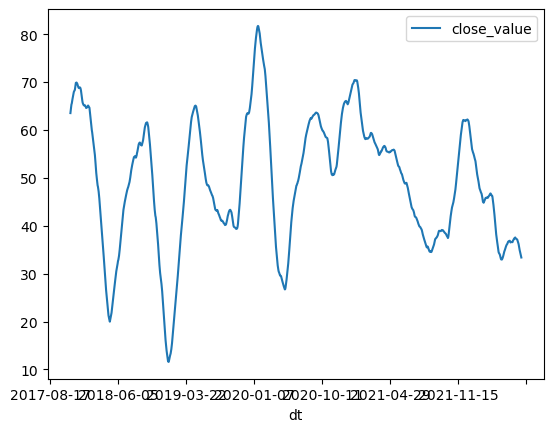

In [65]:
sentiment_proxy[(sentiment_proxy['dt'] >= '2017-08-17') & (sentiment_proxy['dt'] <= '2022-06-06')].set_index(['dt']).rolling(60).mean().plot()

<Axes: >

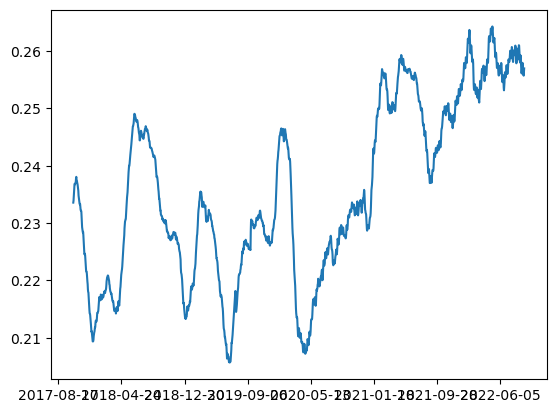

In [63]:
finbert_cluster['finbert_pos'].rolling(60).mean().plot()

<Axes: >

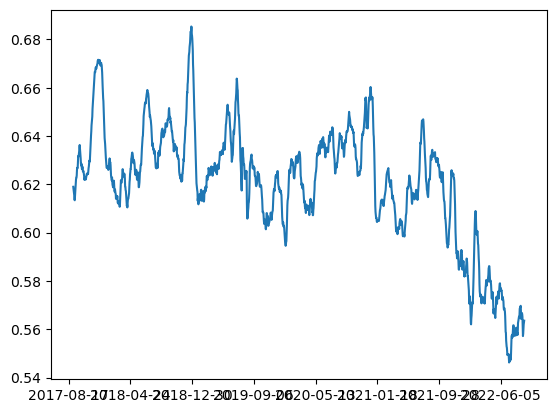

In [61]:
finbert_cluster['finbert_neu'].rolling(20).mean().plot()